# Lab 10 AutoEncoder 



In [1]:
import torchvision
from math import floor, ceil
import torch
from torch import nn
import tqdm
import numpy as np
torch.cuda.empty_cache()
batch_size_train = 64 #Define train batch size
batch_size_test  = 256 #Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size_test,
                                          shuffle=True)

print(len(train_loader))
print(len(test_loader))

938
40


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('gpu')
print(device)

cuda:0


In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=64, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [17]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2,stride=2),
            Flatten(),
            nn.Linear(7*7*64,5*5*64),
            nn.Tanh(),
            nn.Linear(5*5*64,3*3*64)
        )
        self.decoder =nn.Sequential(
            nn.Linear(3*3*64,5*5*64),
            nn.Tanh(),
            nn.Linear(5*5*64,7*7*64),
            Unflatten(),
            nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1),
        )
    
    def forward(self,x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out,latent


In [18]:
loss_fn = nn.MSELoss().to(device)
model = AE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay =1e-6)

epochs =10

loss_list =[]
val_loss_list=[]
iteration_list=[]
accuracy_list=[]
log_interval = 200

count=0

for epoch in tqdm.trange(epochs):
  print( '='*40)
  model.train()
  for idx, (data,label) in enumerate(train_loader):
    pred,latent = model(data.to(device))
    loss = loss_fn(pred, data.to(device))

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if idx %log_interval ==0:
      print('Train epoch {} [{}/{} {:.0f}%], loss : {:.4f}'.format(epoch, idx*batch_size_train,
            len(train_loader)*batch_size_train, 100*idx/len(train_loader),loss.item()))
      loss_list.append(loss.item())
      count+=log_interval
      iteration_list.append(count)
  model.eval()
  with torch.no_grad():  
    val_loss =0
    test_num=0
    for data, label in test_loader:
      pred,latent=model(data.to(device))
      val_loss+=loss_fn(pred,data.to(device)).item()
      test_num +=len(label)
    val_loss=val_loss/test_num
    val_loss_list.append(val_loss)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Train epoch 0 [0/60032 0%], loss : 5.4810
Train epoch 0 [12800/60032 21%], loss : 0.2777
Train epoch 0 [25600/60032 43%], loss : 0.1791
Train epoch 0 [38400/60032 64%], loss : 0.1448
Train epoch 0 [51200/60032 85%], loss : 0.1148


 10%|████████▍                                                                           | 1/10 [01:00<09:02, 60.29s/it]

Train epoch 1 [0/60032 0%], loss : 0.1047
Train epoch 1 [12800/60032 21%], loss : 0.1074
Train epoch 1 [25600/60032 43%], loss : 0.0960
Train epoch 1 [38400/60032 64%], loss : 0.0782
Train epoch 1 [51200/60032 85%], loss : 0.0873


 20%|████████████████▊                                                                   | 2/10 [01:30<05:42, 42.85s/it]

Train epoch 2 [0/60032 0%], loss : 0.0792
Train epoch 2 [12800/60032 21%], loss : 0.0714
Train epoch 2 [25600/60032 43%], loss : 0.0682
Train epoch 2 [38400/60032 64%], loss : 0.0694
Train epoch 2 [51200/60032 85%], loss : 0.0647


 30%|█████████████████████████▏                                                          | 3/10 [02:02<04:24, 37.81s/it]

Train epoch 3 [0/60032 0%], loss : 0.0601
Train epoch 3 [12800/60032 21%], loss : 0.0605
Train epoch 3 [25600/60032 43%], loss : 0.0642
Train epoch 3 [38400/60032 64%], loss : 0.0547
Train epoch 3 [51200/60032 85%], loss : 0.0519


 40%|█████████████████████████████████▌                                                  | 4/10 [02:57<04:28, 44.69s/it]

Train epoch 4 [0/60032 0%], loss : 0.0532
Train epoch 4 [12800/60032 21%], loss : 0.0501
Train epoch 4 [25600/60032 43%], loss : 0.0524
Train epoch 4 [38400/60032 64%], loss : 0.0474
Train epoch 4 [51200/60032 85%], loss : 0.0460


 50%|██████████████████████████████████████████                                          | 5/10 [04:08<04:29, 53.95s/it]

Train epoch 5 [0/60032 0%], loss : 0.0465
Train epoch 5 [12800/60032 21%], loss : 0.0446
Train epoch 5 [25600/60032 43%], loss : 0.0417
Train epoch 5 [38400/60032 64%], loss : 0.0405
Train epoch 5 [51200/60032 85%], loss : 0.0428


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [04:38<03:03, 45.93s/it]

Train epoch 6 [0/60032 0%], loss : 0.0387
Train epoch 6 [12800/60032 21%], loss : 0.0382
Train epoch 6 [25600/60032 43%], loss : 0.0374
Train epoch 6 [38400/60032 64%], loss : 0.0400
Train epoch 6 [51200/60032 85%], loss : 0.0385


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [05:11<02:05, 41.67s/it]

Train epoch 7 [0/60032 0%], loss : 0.0386
Train epoch 7 [12800/60032 21%], loss : 0.0346
Train epoch 7 [25600/60032 43%], loss : 0.0350
Train epoch 7 [38400/60032 64%], loss : 0.0348
Train epoch 7 [51200/60032 85%], loss : 0.0329


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [06:08<01:32, 46.48s/it]

Train epoch 8 [0/60032 0%], loss : 0.0315
Train epoch 8 [12800/60032 21%], loss : 0.0333
Train epoch 8 [25600/60032 43%], loss : 0.0319
Train epoch 8 [38400/60032 64%], loss : 0.0311
Train epoch 8 [51200/60032 85%], loss : 0.0293


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [06:41<00:42, 42.32s/it]

Train epoch 9 [0/60032 0%], loss : 0.0325
Train epoch 9 [12800/60032 21%], loss : 0.0324
Train epoch 9 [25600/60032 43%], loss : 0.0293
Train epoch 9 [38400/60032 64%], loss : 0.0312
Train epoch 9 [51200/60032 85%], loss : 0.0295


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [07:23<00:00, 44.38s/it]


In [20]:
data = data.cpu().detach().numpy()
pred = pred.cpu().detach().numpy()
data = data.squeeze()
pred =pred.squeeze()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

# Visualization 

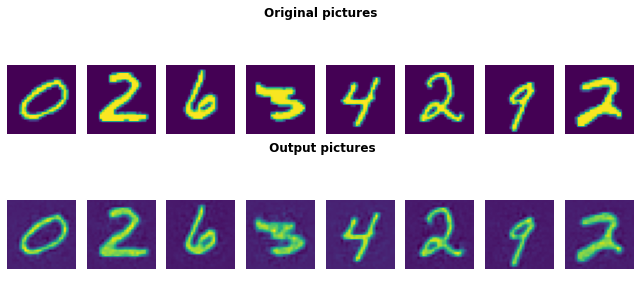

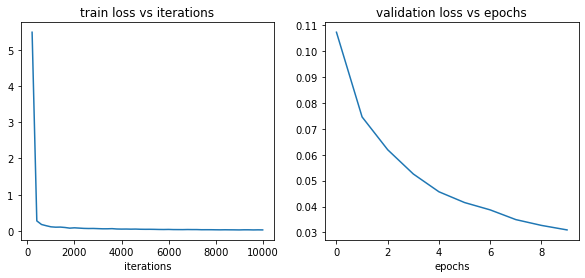

In [21]:
from matplotlib.gridspec import SubplotSpec
import matplotlib.pyplot as plt

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

def  visualize(num_pairs=5):

  fig, ax = plt.subplots(2,num_pairs,figsize=(9,4))
  grid =plt.GridSpec(2,num_pairs)
  create_subtitle(fig,grid[0,::],'Original pictures')
  create_subtitle(fig,grid[1,::], '\n Output pictures')
  for i in range(num_pairs):
    ax[0][i].imshow(data[i,:,:])
    ax[1][i].imshow(pred[i,:,:])
    ax[0][i].axis('off')
    ax[1][i].axis('off')

  fig.tight_layout()
  fig.set_facecolor('w')
  fig,ax = plt.subplots(1,2,figsize=(10,4))
  ax[0].plot(iteration_list,loss_list)
  ax[1].plot(val_loss_list)
  ax[0].set_title('train loss vs iterations')
  ax[0].set_xlabel('iterations')
  ax[1].set_title('validation loss vs epochs')
  ax[1].set_xlabel('epochs')
  
visualize(8)

## PCA on code vector in latent space

In [ ]:
model = model.to('cpu')

latent_testloader = torch.utils.data.DataLoader(test_set,batch_size=10000,shuffle=False)
for data, label in latent_testloader:
    pred, latent = model(data)
    
U, S, VT = torch.pca_lowrank(latent)    

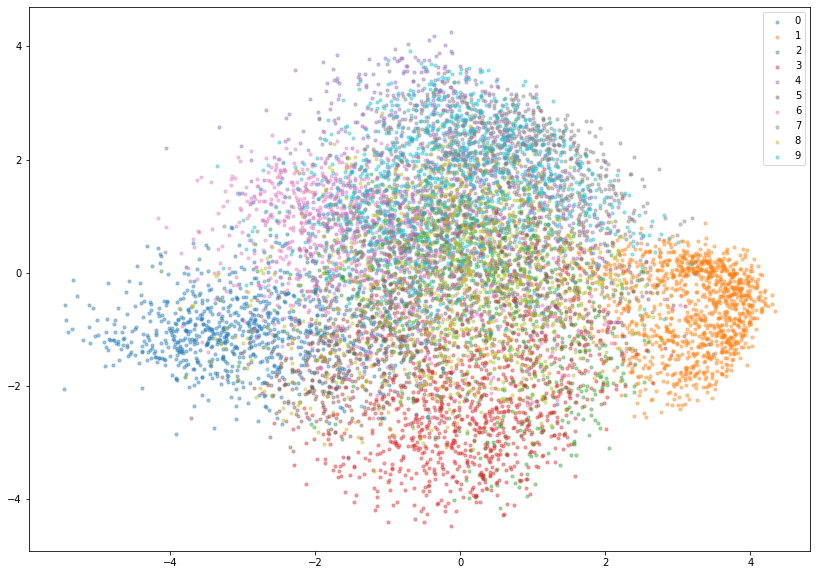

In [32]:
plt.figure(figsize = (14,10))

for i in range(10):
  mask = label == i
  Y = (U[mask]@torch.diag(S)).detach()
  plt.scatter(Y[:,0], Y[:,1], label = i, alpha = 0.4, s = 10)
  plt.legend()

## Direct PCA on input

In [ ]:
data = data.view(data.shape[0],-1).numpy()
U, S, VT = torch.pca_lowrank(latent)    

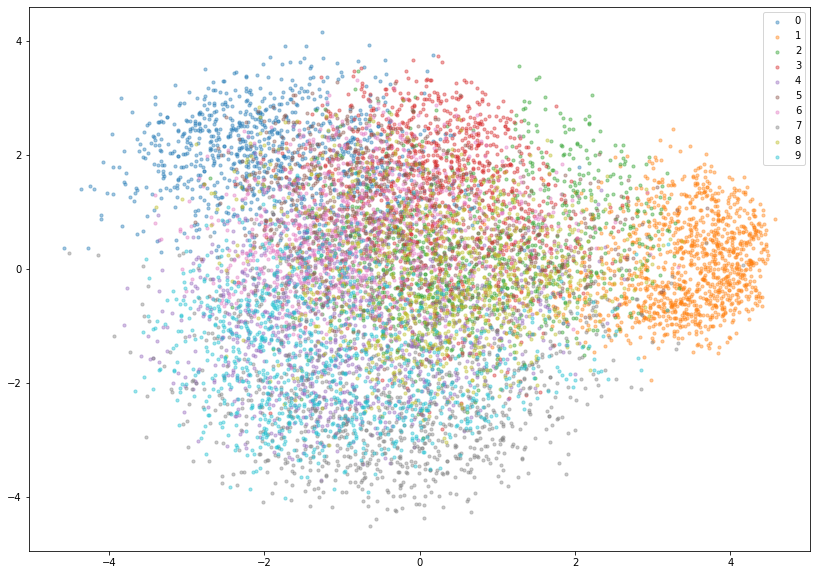

In [37]:
plt.figure(figsize = (14,10))

for i in range(10):
  mask = label == i
  Y = (U[mask]@torch.diag(S)).detach()
  plt.scatter(Y[:,0], Y[:,1], label = i, alpha = 0.4, s = 10)
  plt.legend()